In [ ]:
!pip3 install imblearn

In [93]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, average_precision_score
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from yellowbrick.classifier import PrecisionRecallCurve
import matplotlib.pyplot as plt

In [18]:
X, y = make_classification(n_samples=3000, n_clusters_per_class=10, n_classes=5, n_informative=500, n_features=800)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [19]:
print(classification_report(y_train, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       314
           1       1.00      1.00      1.00       312
           2       1.00      1.00      1.00       285
           3       1.00      1.00      1.00       280
           4       1.00      1.00      1.00       309

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



In [109]:
encoder.classes_

array([0, 1, 2, 3, 4])

In [112]:
# Model performance metrics
encoder = LabelBinarizer()
encoder.fit(y_train)
y_test_enc = encoder.transform(y_test)
y_pred_proba = ovr_estimator.predict_proba(X_test)

for i, c in enumerate(encoder.classes_):
    # ROC
    roc_auc = roc_auc_score(y_test_enc[:, i], y_pred_proba[:, i])
    print(roc_auc)


0.5218257854172187
0.5079509831860929
0.5431909911076578
0.5430694032975033
0.5761305295731064


In [20]:
scaler = StandardScaler()
fs_est = LogisticRegression(max_iter=1000, n_jobs=1)
fs = RFECV(fs_est, min_features_to_select=500, scoring="average_precision", step=0.2, cv=5, verbose=2)
# sampling = SMOTEENN(sampling_strategy=0.4)
sampling = SMOTE(sampling_strategy=0.4)
clf = CatBoostClassifier(iterations=500, loss_function="Logloss", allow_writing_files=False,
                         early_stopping_rounds=50, verbose=False)

pipe = Pipeline([
    ("scaler", scaler),
    ("feature_selection", fs),
    ("sampling", sampling),
    ("clf", clf),
], verbose=True)

ovr_estimator = OneVsRestClassifier(pipe, n_jobs=6, verbose=1)


In [30]:
ovr_estimator.fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   30.4s finished


OneVsRestClassifier(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('feature_selection',
                                               RFECV(cv=5,
                                                     estimator=LogisticRegression(max_iter=1000,
                                                                                  n_jobs=1),
                                                     min_features_to_select=500,
                                                     scoring='average_precision',
                                                     step=0.2, verbose=2)),
                                              ('sampling',
                                               SMOTE(sampling_strategy=0.4)),
                                              ('clf',
                                               <catboost.core.CatBoostClassifier object at 0x16ce68a90>)],
                                       verbose=True),
                    n_jobs=6, verbose=1)

In [84]:
binarizer = LabelBinarizer()
binarizer.fit(y_train)
y_test_enc = binarizer.transform(y_test)

y_pred_proba = ovr_estimator.predict_proba(X_test)

In [103]:
len(y_test_enc[:, 0])

1500

In [92]:
roc_auc_score(y_test, y_pred_proba, multi_class="ovr")

0.5384335385163158

In [104]:
average_precision_score(y_test_enc[:, 0], y_pred_proba[:, 0])

0.20458587436360334

In [67]:
def plot_precision_recall_curve(estimator, X_train, y_train, X_test, y_test):
    encoder = LabelBinarizer()
    y_train_enc = encoder.fit_transform(y_train)
    y_test_enc = encoder.transform(y_test)

    y_pred_proba = estimator.predict_proba(X_test)

    precision = dict()
    recall = dict()
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(len(encoder.classes_)):
        precision[i], recall[i], _ = precision_recall_curve(y_test_enc[:, i],
                                                            y_pred_proba[:, i])
        plt.plot(recall[i], precision[i], lw=2, label=encoder.classes_[i])

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.savefig("test.png")

[[0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 ...
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 1 0]]


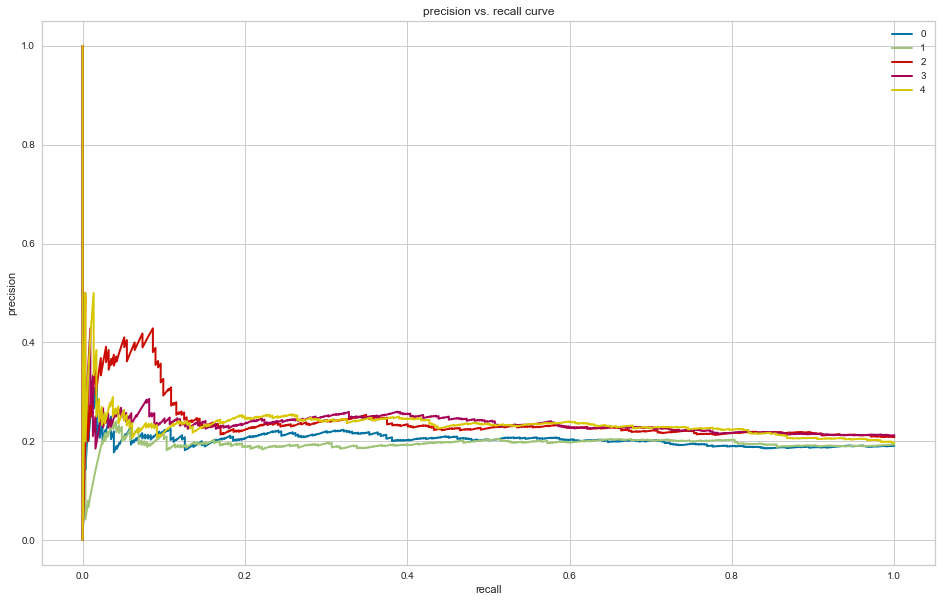

In [68]:
plot_precision_recall_curve(ovr_estimator, X_train, y_train, X_test, y_test)

In [58]:
!pwd

/Users/mregan/Dev/litmus/user_data/notebooks
